Loading Dataset Covid-19 Radiography Dataset

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, join, isdir
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
import keras
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
# from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directory where arrays are saved
directory = '/content/drive/MyDrive/arrays27'

# File paths
x_train_path = os.path.join(directory, 'x_train.npy')
x_test_path = os.path.join(directory, 'x_test.npy')
x_val_path = os.path.join(directory, 'x_val.npy')
y_train_path = os.path.join(directory, 'y_train.npy')
y_test_path = os.path.join(directory, 'y_test.npy')
y_val_path = os.path.join(directory, 'y_val.npy')

# Load arrays
x_train = np.load(x_train_path)
x_test = np.load(x_test_path)
x_val = np.load(x_val_path)
y_train = np.load(y_train_path)
y_test = np.load(y_test_path)
y_val = np.load(y_val_path)

print(f"Loaded data from {directory}")
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

# Example: Splitting the loaded data for further processing
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


Loaded data from /content/drive/MyDrive/arrays27
(3751, 299, 299, 3) (1042, 299, 299, 3) (417, 299, 299, 3) (3751,) (1042,) (417,)


In [ ]:
print("y_test shape")
y_test.shape

y_test shape


(1042,)

Training Base Models
1. InceptionV3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from tensorflow.keras.utils import to_categorical # Import to_categorical

# Set the number of classes
num_classes = 4  # Replace with the actual number of classes
# Load the base InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks: early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='Inception28_test.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=num_classes) # Convert to one-hot encoding
y_val = to_categorical(y_val, num_classes=num_classes)   # Convert to one-hot encoding

# Initial training phase
print("Starting initial training phase...")
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=50,  # Example number of epochs
                    batch_size=64,
                    callbacks=[early_stopping, model_checkpoint])

# Fine-tuning phase
# Unfreeze some layers in the base model
for layer in base_model.layers[-20:]:  # Example: Unfreeze last 20 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training (fine-tuning)
print("Starting fine-tuning phase...")
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=30,  # Example number of epochs
                    batch_size=64,
                    callbacks=[early_stopping, model_checkpoint])

Starting initial training phase...


convert labels to one-hot encoding for training

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test, num_classes=4) # Convert to one-hot encoding
y_test.shape

(1042, 4)

In [ ]:
# Evaluate the model on the test data
# Convert y_test to one-hot encoded format
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

33/33 [==============================] - 12s 222ms/step - loss: 0.2662 - accuracy: 0.9155
Test loss: 0.2661718726158142
Test accuracy: 0.9155470132827759


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))


33/33 [==============================] - 5s 112ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       274
           1       0.91      0.83      0.87       249
           2       0.84      0.94      0.89       256
           3       0.97      0.95      0.96       263

    accuracy                           0.92      1042
   macro avg       0.92      0.91      0.91      1042
weighted avg       0.92      0.92      0.92      1042



2. MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Adjust num_classes based on your problem

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune some layers of the base model
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(filepath='MobileNetV2_28.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stop],
    verbose=1
)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 1.2075 - accuracy: 0.4689
Epoch 1: val_loss improved from inf to 1.27593, saving model to MobileNetV2_28.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 25s 258ms/step - loss: 1.2075 - accuracy: 0.4689 - val_loss: 1.2759 - val_accuracy: 0.4341
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.8452 - accuracy: 0.7110
Epoch 2: val_loss improved from 1.27593 to 1.15214, saving model to MobileNetV2_28.hdf5
59/59 [==============================] - 10s 169ms/step - loss: 0.8452 - accuracy: 0.7110 - val_loss: 1.1521 - val_accuracy: 0.5947
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.7790
Epoch 3: val_loss improved from 1.15214 to 1.07061, saving model to MobileNetV2_28.hdf5
59/59 [==============================] - 10s 166ms/step - loss: 0.6576 - accuracy: 0.7790 - val_loss: 1.0706 - val_accuracy: 0.6379
Epoch 4/100
59/59 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.8136
Epoch 4: val_loss improved from 1.07061 to 1.00827, saving model to MobileNetV2_28.hdf5
59/59 [==============================] - 10s 176ms/step

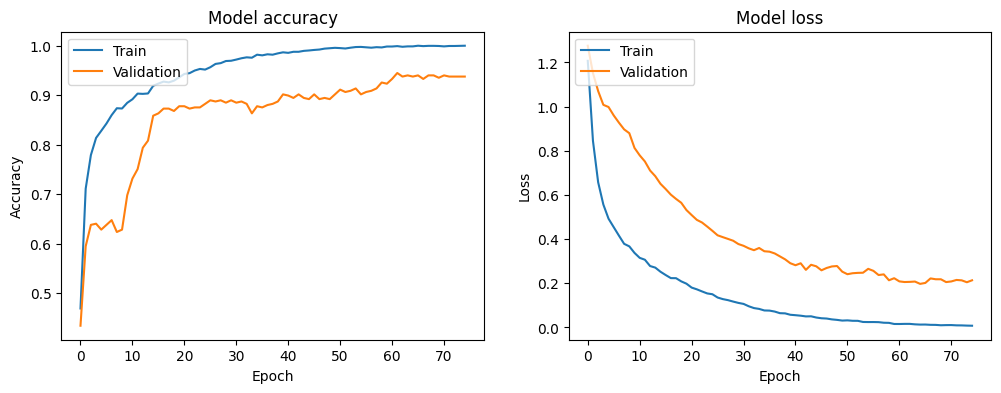

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])  # Plot only the available history
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])  # Plot only the available history
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

33/33 [==============================] - 2s 66ms/step - loss: 0.2739 - accuracy: 0.9031
Test loss: 0.2739
Test accuracy: 0.9031


Shape of y_test_flat: (1042,)
Unique values in y_test_flat: [0 1 2 3]
Shape of y_pred_classes: (1042,)
Unique values in y_pred_classes: [0 1 2 3]


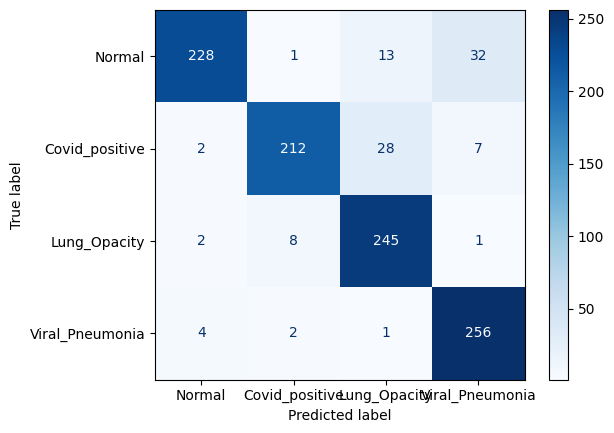

                 precision    recall  f1-score   support

         Normal       0.97      0.83      0.89       274
 Covid_positive       0.95      0.85      0.90       249
   Lung_Opacity       0.85      0.96      0.90       256
Viral_Pneumonia       0.86      0.97      0.92       263

       accuracy                           0.90      1042
      macro avg       0.91      0.90      0.90      1042
   weighted avg       0.91      0.90      0.90      1042



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure y_test is in integer format (not one-hot encoded)
y_test_flat = np.argmax(y_test, axis=1)

# Ensure y_pred is in integer format
y_pred_classes = np.argmax(y_pred, axis=1)

# Print shapes and unique values for debugging
print("Shape of y_test_flat:", y_test_flat.shape)
print("Unique values in y_test_flat:", np.unique(y_test_flat))
print("Shape of y_pred_classes:", y_pred_classes.shape)
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))

# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print(classification_report(y_test_flat, y_pred_classes, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))


3. NasNetMobile model

In [ ]:
import numpy as np
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
num_classes = 4  # Adjust based on your specific problem

# Load the NASNetMobile model with pre-trained ImageNet weights
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(filepath='NASNet28.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stop],
    verbose=1
)


# Unfreeze some layers of the base model and fine-tune
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stop],
    verbose=1
)


19993432/19993432 [==============================] - 0s 0us/step
Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 6.1964 - accuracy: 0.3292
Epoch 1: val_loss improved from inf to 1.20308, saving model to NASNet28.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 38s 387ms/step - loss: 6.1964 - accuracy: 0.3292 - val_loss: 1.2031 - val_accuracy: 0.6307
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 4.3263 - accuracy: 0.4311
Epoch 2: val_loss improved from 1.20308 to 1.10192, saving model to NASNet28.hdf5
59/59 [==============================] - 15s 257ms/step - loss: 4.3263 - accuracy: 0.4311 - val_loss: 1.1019 - val_accuracy: 0.6427
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 3.5916 - accuracy: 0.4783
Epoch 3: val_loss improved from 1.10192 to 1.02700, saving model to NASNet28.hdf5
59/59 [==============================] - 17s 283ms/step - loss: 3.5916 - accuracy: 0.4783 - val_loss: 1.0270 - val_accuracy: 0.6787
Epoch 4/20
59/59 [==============================] - ETA: 0s - loss: 3.1531 - accuracy: 0.5007
Epoch 4: val_loss did not improve from 1.02700
59/59 [==============================] - 14s 241ms/step - loss: 3.1531 - accuracy: 0.5007 - val_loss: 1.0757 - 

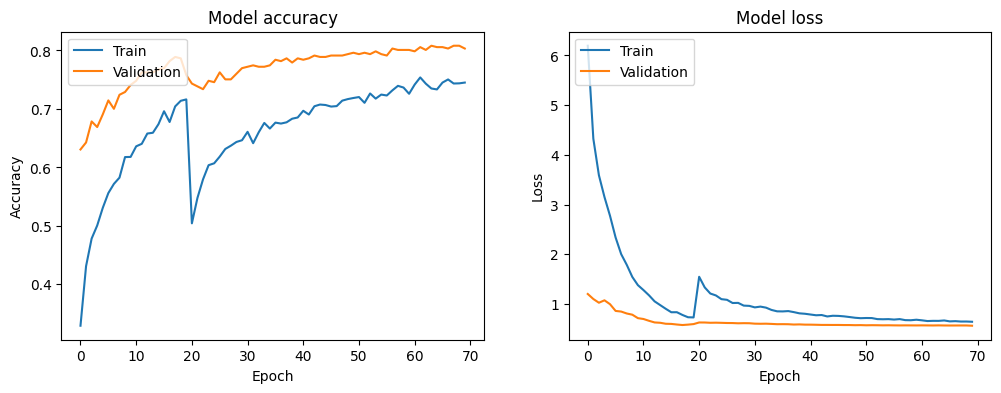

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


33/33 [==============================] - 6s 135ms/step - loss: 0.5778 - accuracy: 0.7793
Test loss: 0.5778181552886963
Test accuracy: 0.7792706489562988
33/33 [==============================] - 8s 107ms/step
Shape of y_test_flat: (1042,)
Unique values in y_test_flat: [0 1 2 3]
Shape of y_pred_classes: (1042,)
Unique values in y_pred_classes: [0 1 2 3]


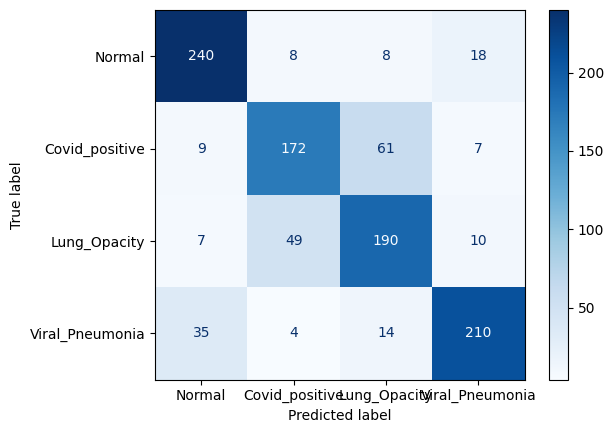

                 precision    recall  f1-score   support

         Normal       0.82      0.88      0.85       274
 Covid_positive       0.74      0.69      0.71       249
   Lung_Opacity       0.70      0.74      0.72       256
Viral_Pneumonia       0.86      0.80      0.83       263

       accuracy                           0.78      1042
      macro avg       0.78      0.78      0.78      1042
   weighted avg       0.78      0.78      0.78      1042



In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

# Make predictions on the test set
y_pred = model.predict(x_test)

# Ensure y_test is in integer format (not one-hot encoded)
y_test_flat = np.argmax(y_test, axis=1)

# Ensure y_pred is in integer format
y_pred_classes = np.argmax(y_pred, axis=1)

# Print shapes and unique values for debugging
print("Shape of y_test_flat:", y_test_flat.shape)
print("Unique values in y_test_flat:", np.unique(y_test_flat))
print("Shape of y_pred_classes:", y_pred_classes.shape)
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))

# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print(classification_report(y_test_flat, y_pred_classes, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))


4. ResNet50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Load the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
num_classes = 4
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Adjust num_classes based on your problem

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(filepath='ResNet50_29th.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes) # Do the same for validation data

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Fine-tuning: Unfreeze some layers and retrain
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stop],
    verbose=1
)


Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.7710
Epoch 1: val_loss improved from inf to 0.27018, saving model to ResNet50_29th.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 50s 627ms/step - loss: 0.5786 - accuracy: 0.7710 - val_loss: 0.2702 - val_accuracy: 0.9161
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8750
Epoch 2: val_loss improved from 0.27018 to 0.22736, saving model to ResNet50_29th.hdf5
59/59 [==============================] - 25s 417ms/step - loss: 0.3390 - accuracy: 0.8750 - val_loss: 0.2274 - val_accuracy: 0.9281
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.8998
Epoch 3: val_loss improved from 0.22736 to 0.20140, saving model to ResNet50_29th.hdf5
59/59 [==============================] - 24s 400ms/step - loss: 0.2826 - accuracy: 0.8998 - val_loss: 0.2014 - val_accuracy: 0.9400
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9128
Epoch 4: val_loss improved from 0.20140 to 0.18038, saving model to ResNet50_29th.hdf5
59/59 [==============================] - 23s 397ms/step - los

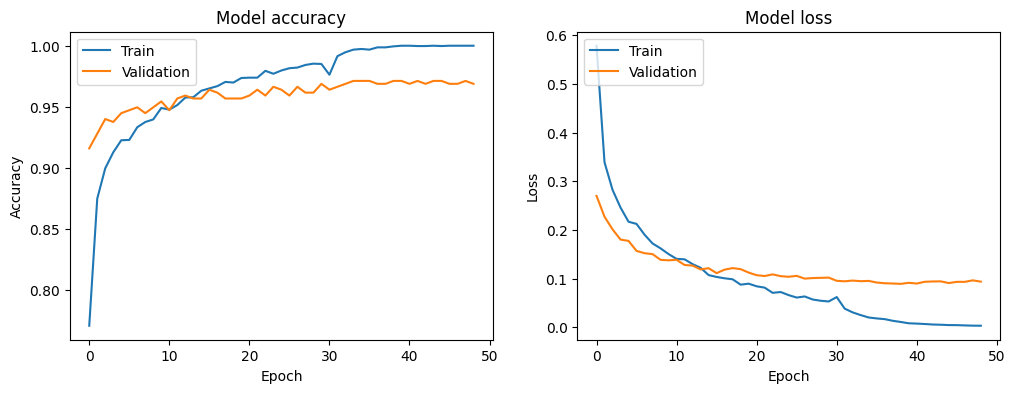

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
y_test_flat = to_categorical(y_test, num_classes=4)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test_flat)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


33/33 [==============================] - 6s 174ms/step - loss: 0.1297 - accuracy: 0.9587
Test loss: 0.1296926885843277
Test accuracy: 0.9587332010269165


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
y_pred_classes = to_categorical(y_test, num_classes=4)
y_pred_classes.shape

(1042, 4)

Shape of y_test_flat: (1042, 4)
Unique values in y_test_flat: [0. 1.]
Shape of y_pred_classes: (1042,)
Unique values in y_pred_classes: [0 1 2 3]


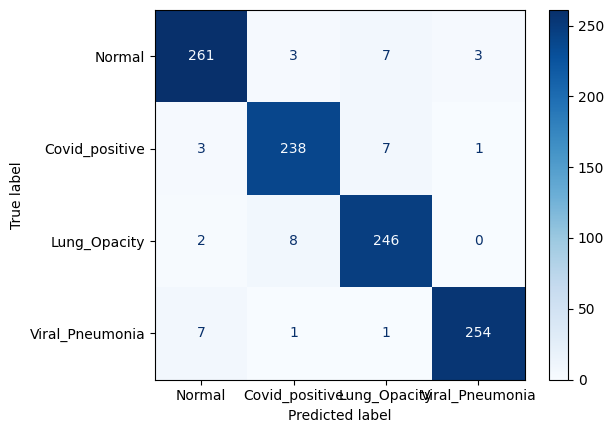

                 precision    recall  f1-score   support

         Normal       0.96      0.95      0.95       274
 Covid_positive       0.95      0.96      0.95       249
   Lung_Opacity       0.94      0.96      0.95       256
Viral_Pneumonia       0.98      0.97      0.98       263

       accuracy                           0.96      1042
      macro avg       0.96      0.96      0.96      1042
   weighted avg       0.96      0.96      0.96      1042



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure y_test is in integer format (not one-hot encoded)
y_test_flat = to_categorical(y_test, num_classes=4)

# y_pred is already in the correct format, no need to apply to_categorical
y_pred_classes = np.argmax(y_pred, axis=1) # Convert one-hot encoded y_pred to class indices

# Print shapes and unique values for debugging
print("Shape of y_test_flat:", y_test_flat.shape)
print("Unique values in y_test_flat:", np.unique(y_test_flat))
print("Shape of y_pred_classes:", y_pred_classes.shape)
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))

# Generate confusion matrix
cm = confusion_matrix(y_test_flat.argmax(axis=1), y_pred_classes) # Convert y_test_flat to class indices

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print(classification_report(y_test_flat.argmax(axis=1), y_pred_classes, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])) # Convert y_test_flat to class indices

In [ ]:
from google.colab import drive
import os
# Step 2: Create a Folder
folder_path = '/content/drive/My Drive/Models'
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created at {folder_path}")

# Step 3: Save the Model
save_path = os.path.join(folder_path, 'Resnet50.hdf5')
model.save(save_path)
print(f"Model saved to {save_path}")


Folder created at /content/drive/My Drive/Models


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/Models/Resnet50.hdf5


5. Xception Model

In [ ]:
from google.colab import drive
import os
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (299 , 299 , 3),

    )

x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(4, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model1 = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

# Compile the model
model1.compile(
    # Set optimizer to Adam(0.0001)
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    # Change the loss function here
    loss='sparse_categorical_crossentropy',
    # Set metrics to accuracy
    metrics=['accuracy']
)



model1.summary()
# Define callbacks
checkpoint = ModelCheckpoint(filepath='Xception.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train the model
history = model1.fit(
    x_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stop],
    verbose=1
)

folder_path = '/content/drive/My Drive/Models'

# Define the path to save the model in the new folder
save_path = os.path.join(folder_path, 'Xception.hdf5')

# Save the trained model to the specified path
model1.save(save_path)
print(f"Model saved to {save_path}")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 149s 959ms/step - loss: 0.3532 - accuracy: 0.8736 - val_loss: 0.3505 - val_accuracy: 0.8801
Epoch 2/20
118/118 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9669
Epoch 2: val_loss improved from 0.35052 to 0.12728, saving model to Xception.hdf5
118/118 [==============================] - 104s 885ms/step - loss: 0.1050 - accuracy: 0.9669 - val_loss: 0.1273 - val_accuracy: 0.9736
Epoch 3/20
118/118 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9827
Epoch 3: val_loss improved from 0.12728 to 0.11080, saving model to Xception.hdf5
118/118 [==============================] - 104s 885ms/step - loss: 0.0617 - accuracy: 0.9827 - val_loss: 0.1108 - val_accuracy: 0.9712
Epoch 4/20
118/118 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9813
Epoch 4: val_loss did not improve from 0.11080
118/118 [==============================] - 103s 875ms/step - loss: 0.0606 - accuracy: 0.9813 - v

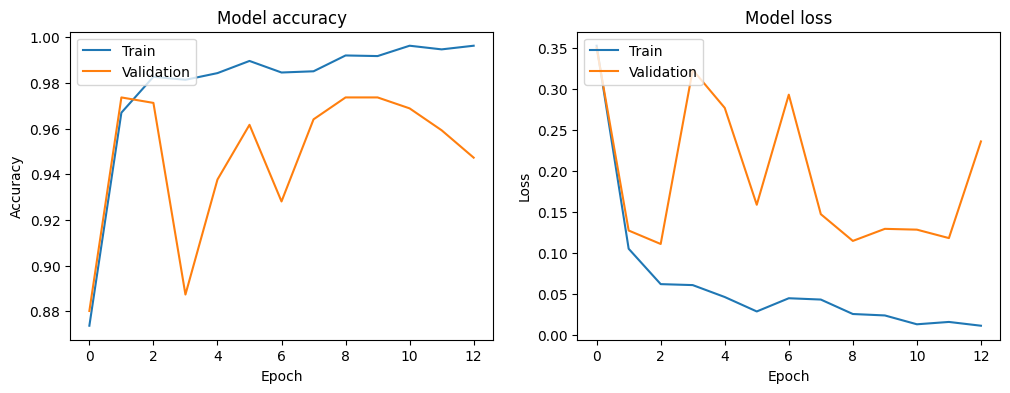

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


33/33 [==============================] - 11s 317ms/step - loss: 0.1156 - accuracy: 0.9635
Test loss: 0.11564625799655914
Test accuracy: 0.9635316729545593
33/33 [==============================] - 8s 223ms/step
Shape of y_test_flat: (1042,)
Shape of y_pred_classes: (1042,)
              precision    recall  f1-score   support

     Class 0       0.94      0.97      0.96       274
     Class 1       0.99      0.94      0.97       249
     Class 2       0.94      0.95      0.95       256
     Class 3       0.98      0.98      0.98       263

    accuracy                           0.96      1042
   macro avg       0.96      0.96      0.96      1042
weighted avg       0.96      0.96      0.96      1042



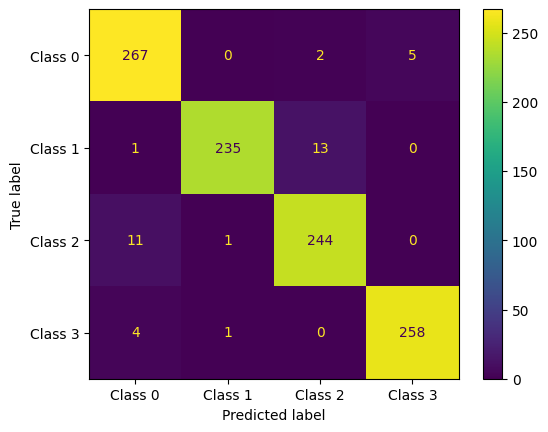

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set
loss, accuracy = model1.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

# Generate predictions on the test set
y_pred = model1.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Flatten the true labels
y_test_flat = y_test.flatten()

# Print the shapes of y_test_flat and y_pred_classes for debugging
print(f'Shape of y_test_flat: {y_test_flat.shape}')
print(f'Shape of y_pred_classes: {y_pred_classes.shape}')

# Generate a classification report
print(classification_report(y_test_flat, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))

# Generate a confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
disp.plot()


6. VGG16 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Assuming x_train, y_train, x_val, y_val are already defined

# Set the number of classes
num_classes = 4  # Replace with the actual number of classes

# Load the base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks: early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Reshape y_train and y_val if necessary and convert labels to one-hot encoded format
# Assuming original shape of y_train and y_val is (None, 4, 4, 4)
y_train = to_categorical(y_train, num_classes=num_classes) # Convert to one-hot encoding
y_val = to_categorical(y_val, num_classes=num_classes)   # Convert to one-hot encoding


# Initial training phase
print("Starting initial training phase...")
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=50,  # Example number of epochs
                    batch_size=64,
                    callbacks=[early_stopping, model_checkpoint])

# Fine-tuning phase
# Unfreeze some layers in the base model
for layer in base_model.layers[-4:]:  # Example: Unfreeze last 4 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training (fine-tuning)
print("Starting fine-tuning phase...")
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=30,  # Example number of epochs
                    batch_size=64,
                    callbacks=[early_stopping, model_checkpoint])

Starting initial training phase...
Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.9834 - accuracy: 0.7614
Epoch 1: val_loss improved from inf to 0.27687, saving model to vgg16_model.h5
59/59 [==============================] - 87s 1s/step - loss: 0.9834 - accuracy: 0.7614 - val_loss: 0.2769 - val_accuracy: 0.9113
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.9072
Epoch 2: val_loss improved from 0.27687 to 0.18358, saving model to vgg16_model.h5
59/59 [==============================] - 36s 611ms/step - loss: 0.2649 - accuracy: 0.9072 - val_loss: 0.1836 - val_accuracy: 0.9496
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9171
Epoch 3: val_loss improved from 0.18358 to 0.15636, saving model to vgg16_model.h5
59/59 [==============================] - 35s 602ms/step - loss: 0.2309 - accuracy: 0.9171 - val_loss: 0.1564 - val_accuracy: 0.9520
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9376
Epoch 4: val_loss did not improve from 0.15636
59/59 [==============================] - 33s 568ms/step - loss: 0.1778 - accuracy: 0.9376 - val_loss: 0.1760 - val_accuracy: 0.9448
Epoch 5/50
59/59 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9517
Epoch 5: val_loss did not 

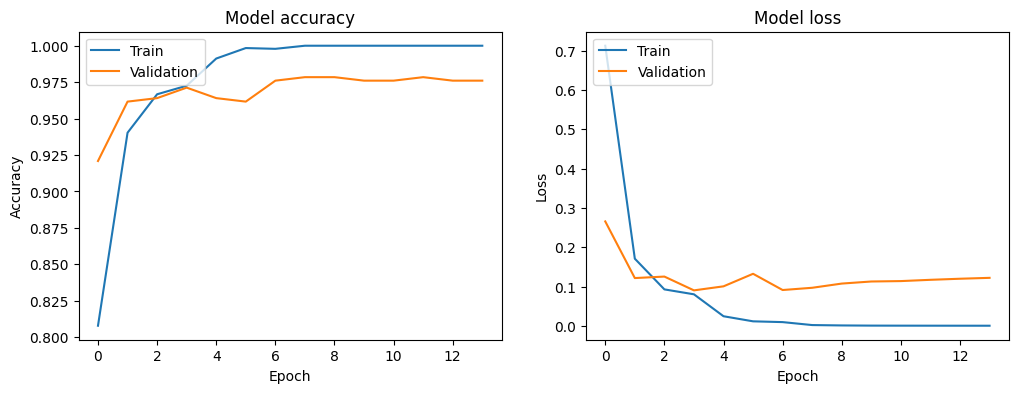

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
x_test.shape

(1042, 299, 299, 3)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test, num_classes=4) # Convert to one-hot encoding
y_test.shape

(1042, 4)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

33/33 [==============================] - 9s 259ms/step - loss: 0.1048 - accuracy: 0.9645
Test loss: 0.1048
Test accuracy: 0.9645


In [ ]:
y_train.shape# Make predictions on the test set
y_pred = model.predict(x_test)

# Ensure y_test is in integer format (not one-hot encoded)
y_test_flat = np.argmax(y_test, axis=1)

# Ensure y_pred is in integer format
y_pred_classes = np.argmax(y_pred, axis=1)

# Print shapes and unique values for debugging
print("Shape of y_test_flat:", y_test_flat.shape)
print("Unique values in y_test_flat:", np.unique(y_test_flat))
print("Shape of y_pred_classes:", y_pred_classes.shape)
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))

33/33 [==============================] - 9s 266ms/step
Shape of y_test_flat: (1042,)
Unique values in y_test_flat: [0 1 2 3]
Shape of y_pred_classes: (1042,)
Unique values in y_pred_classes: [0 1 2 3]


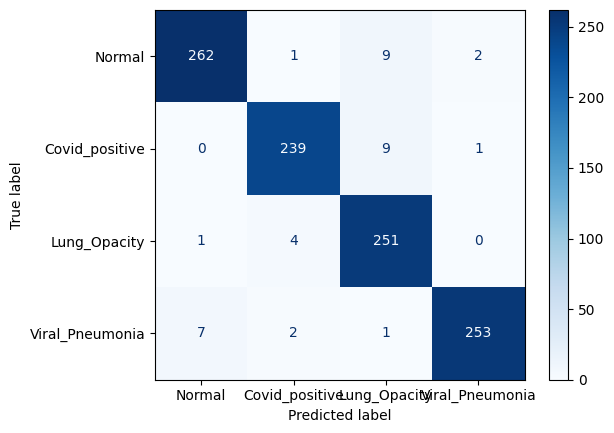

                 precision    recall  f1-score   support

         Normal       0.97      0.96      0.96       274
 Covid_positive       0.97      0.96      0.97       249
   Lung_Opacity       0.93      0.98      0.95       256
Viral_Pneumonia       0.99      0.96      0.97       263

       accuracy                           0.96      1042
      macro avg       0.96      0.96      0.96      1042
   weighted avg       0.97      0.96      0.96      1042



In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print(classification_report(y_test_flat, y_pred_classes, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))


In [ ]:
from google.colab import drive
import os
# Step 2: Create a Folder
folder_path = '/content/drive/My Drive/Models'
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created at {folder_path}")

# Step 3: Save the Model
save_path = os.path.join(folder_path, 'VGG16_0.hdf5')
model.save(save_path)
print(f"Model saved to {save_path}")


Folder created at /content/drive/My Drive/Models


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/Models/VGG16_0.hdf5
